# Sentiment Analysis using Recurrent Neural Networks
## Introduction
A basic task in sentiment analysis is classifying the polarity of a given text at the document, sentence, or feature/aspect level—whether the expressed opinion in a document, a sentence or an entity feature/aspect is positive, negative, or neutral.

Sentiment analysis is widely applied to voice of the customer materials such as reviews and survey responses, online and social media, and healthcare materials for applications that range from marketing to customer service to clinical medicine.

Sentiment Analysis is a common NLP task that Data Scientists need to perform. **This is a guide to creating a movie review classifier in Keras using Recurrent Neural Networks.**

## Importing Libraries

In [0]:
import os
import sys
import re
import pickle
from collections import defaultdict

import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from sklearn.metrics import roc_curve,auc,confusion_matrix
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding, Dense, Input, Flatten, Concatenate, Dropout
from keras.layers import Conv1D, GlobalMaxPool1D, Dropout, LSTM, GRU, Bidirectional, TimeDistributed 
from keras.models import Model, load_model

from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

from nltk import tokenize
import matplotlib.pyplot as plt
iteration1 = True

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data Overview
For the purpose of this analysis we’ll be using a dataset of 50,000 movie reviews taken from IMDb. 
The data was compiled by Andrew Maas and can be found here: https://ai.stanford.edu/~amaas/data/sentiment/

The data is split evenly with 25k reviews intended for training and 25k for testing your classifier. Moreover, each set has 12.5k positive and 12.5k negative reviews.

IMDb lets users rate movies on a scale from 1 to 10. To label these reviews the curator of the data labeled anything with ≤ 4 stars as negative and anything with ≥ 7 stars as positive. Reviews with 5 or 6 stars were left out.

In [0]:
def load_dataset(path):
    
    train_texts,train_labels = [],[]
    test_texts,test_labels = [],[]
    
    for dataset in ['train', 'test']:
        for category in ['pos', 'neg']:
            dataset_path = os.path.join(path, dataset, category)
            for filename in sorted(os.listdir(dataset_path)):
                if filename.endswith('.txt'):
                    with open(os.path.join(dataset_path, filename), encoding="utf8") as f:

                        label = 1 if category == 'pos' else 0
                        if dataset == 'train': 
                            train_texts.append(f.read())
                            train_labels.append(label)
                        else: 
                            test_texts.append(f.read())
                            test_labels.append(label)

    # Converting to np.array
    train_texts = np.array(train_texts)
    train_labels = np.array(train_labels)
    test_texts = np.array(test_texts)
    test_labels = np.array(test_labels)

    # Shuffle the training data
    permutation = np.random.permutation(len(train_texts))
    train_texts, train_labels = train_texts[permutation], train_labels[permutation]

    # Shuffle the testing data
    permutation = np.random.permutation(len(test_texts))
    test_texts, test_labels = test_texts[permutation], test_labels[permutation]
    
    # Return the dataset
    return train_texts, train_labels, test_texts, test_labels

## Loading Dataset

In [0]:
train_texts, train_labels, test_texts, test_labels = load_dataset("../input/imdb-movie-reviews-dataset/aclimdb/aclImdb")

print ('Train samples shape :', train_texts.shape)
print ('Train labels shape  :', train_labels.shape)
print ('Test samples shape  :', test_texts.shape)
print ('Test labels shape   :', test_labels.shape)

Train samples shape : (25000,)
Train labels shape  : (25000,)
Test samples shape  : (25000,)
Test labels shape   : (25000,)


In [0]:
train_index=[i for i in range(25000)]
data_train = pd.DataFrame({'review':train_texts.astype(str),
                           'sentiment':train_labels
                          },index=train_index)

test_index=[i for i in range(25000,50000)]
data_test = pd.DataFrame({'review':test_texts.astype(str),
                          'sentiment':test_labels
                         },index=test_index)

print("Train data shape : ",data_train.shape)
print("Test data shape  : ",data_test.shape)
data = pd.concat([data_train, data_test])

Train data shape :  (25000, 2)
Test data shape  :  (25000, 2)


## Data Preprocessing

In preprocessing, we are cleaning the movie reviews and making them ready for tokenizing and processing using CNN. The preprocessing steps applied were:
* Removing punctuations from the dataset
* Removing numbers and special characters
* Filling missing entries

In [0]:
puncts = [',', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\',  '~', '@', '£', 
 '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã',  '‘', '∞', 
  '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
def process_text(string):
    string = str(string)
    for punct in puncts:
        string = string.replace(punct, r' ')
    string = re.sub('[0-9]{5,}', '#####', string)
    string = re.sub('[0-9]{4}', '####', string)
    string = re.sub('[0-9]{3}', '###', string)
    string = re.sub('[0-9]{2}', '##', string)
    return string

data['review'] = data['review'].progress_apply(lambda x: process_text(x))

100%|██████████| 50000/50000 [00:06<00:00, 7781.89it/s]


## Exploring Dataset

In [0]:
print('Average word length of review in train is {0:.0f}.'.format(np.mean(data_train['review'].apply(lambda x: len(x.split())))))
print('Average word length of review in train is {0:.0f}.'.format(np.mean(data_test['review'].apply(lambda x: len(x.split())))))

Average word length of review in train is 234.
Average word length of review in train is 229.


In [0]:
print('Max word length of review in train is {0:.0f}.'.format(np.max(data_train['review'].apply(lambda x: len(x.split())))))
print('Max word length of review in train is {0:.0f}.'.format(np.max(data_test['review'].apply(lambda x: len(x.split())))))

Max word length of review in train is 2470.
Max word length of review in train is 2278.


In [0]:
print('Min word length of review in train is {0:.0f}.'.format(np.min(data_train['review'].apply(lambda x: len(x.split())))))
print('Min word length of review in train is {0:.0f}.'.format(np.min(data_test['review'].apply(lambda x: len(x.split())))))

Min word length of review in train is 10.
Min word length of review in train is 4.


## Setting Parameters
Now, based on the exploratory data analysis, we decide the necessary parameters for our dataset. Thus, we decide, the size of the reviews to consider for contextual analysis. We also set the train and validation limit.

In [0]:
MAX_LENGTH = 200
EMBEDDING_DIM = 300
MAX_WORDS = 30000
VALIDATION_SPLIT = 0.3

## Tokenize text
Keras provides a Tokenizer class that can be fit on the training data, can convert text to sequences consistently by calling the text_to_word_sequence() method on the Tokenizer class, and provides access to the dictionary mapping of words to integers in a word_index attribute.

In [0]:
tokenizer = Tokenizer(lower = True,num_words=MAX_WORDS)
full_text = list(data_train['review'].values) + list(data_test['review'].values)
tokenizer.fit_on_texts(full_text)

In [0]:
train_tokenized = tokenizer.texts_to_sequences(data_train['review'].fillna('_NA_'))
test_tokenized = tokenizer.texts_to_sequences(data_test['review'].fillna('_NA_'))
X_train = pad_sequences(train_tokenized,maxlen = MAX_LENGTH, padding = "post", truncating = "post")
X_test = pad_sequences(test_tokenized, maxlen = MAX_LENGTH, padding = "post", truncating = "post")
y = data_train['sentiment']

In [0]:
word_index = tokenizer.word_index
nb_words = min(MAX_WORDS, len(word_index))

## Splitting Data
We split the train data into validation and train data.

In [0]:
x_train, x_val, y_train, y_val = train_test_split(X_train, y, test_size = VALIDATION_SPLIT, random_state=42)

## Glove Word Embeddings

Word embeddings provide a dense representation of words and their relative meanings. GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In [0]:
embedding_path = "../input/glove840b300dtxt/glove.840B.300d.txt"
# function to load the glove embedding into the memory
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

embedding_index = dict(get_coefs(*o.split(" ")) for o in open(embedding_path, encoding='utf-8', errors='ignore'))
all_embs = np.stack(list(embedding_index.values()))
emb_mean,emb_std = all_embs.mean(), all_embs.std()


embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_WORDS: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

## Defining RNN Model 

In [0]:
def RNN_Model():
    inp = Input(shape = (MAX_LENGTH,))
    x = Embedding(nb_words+1,EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_LENGTH,trainable=False)(inp)
    x = Bidirectional(LSTM(512, return_sequences = True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(64,activation = "relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(1,activation="sigmoid")(x)
    model = Model(inputs=inp,outputs=x)
    return model

In [0]:
model_rnn = RNN_Model()
model_rnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
print(model_rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 300)          9000300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 1024)         3330048   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                65600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total para

In [0]:
print("Model fitting - Recurrent Neural network")
if iteration1:
    cp = ModelCheckpoint('model_rnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
    history = model_rnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=8, batch_size=256,callbacks=[cp])
    model_rnn.save("model_rnn.h5")
else:
    history = load_model('model_rnn.h5')
iteration1 = False

Model fitting - Recurrent Neural network
Train on 17500 samples, validate on 7500 samples
Epoch 1/8
17500/17500 [==============================] - 727s 42ms/step - loss: 0.5483 - acc: 0.7186 - val_loss: 0.4342 - val_acc: 0.7987

Epoch 00001: val_acc improved from -inf to 0.79867, saving model to model_rnn.hdf5
Epoch 2/8
17500/17500 [==============================] - 702s 40ms/step - loss: 0.3723 - acc: 0.8425 - val_loss: 0.3320 - val_acc: 0.8548

Epoch 00002: val_acc improved from 0.79867 to 0.85480, saving model to model_rnn.hdf5
Epoch 3/8
17500/17500 [==============================] - 685s 39ms/step - loss: 0.3304 - acc: 0.8658 - val_loss: 0.3081 - val_acc: 0.8704

Epoch 00003: val_acc improved from 0.85480 to 0.87040, saving model to model_rnn.hdf5
Epoch 4/8
17500/17500 [==============================] - 697s 40ms/step - loss: 0.2895 - acc: 0.8840 - val_loss: 0.3196 - val_acc: 0.8607

Epoch 00004: val_acc did not improve from 0.87040
Epoch 5/8
17500/17500 [==========================

## Evaluation of Model
We evaluate our NN model performance by performing the AUC ROC test as well as plotting the following graph:
* Training loss v/s validation loss
* Training accuracy v/s validation accuracy

AUC for RNN is 0.952295904


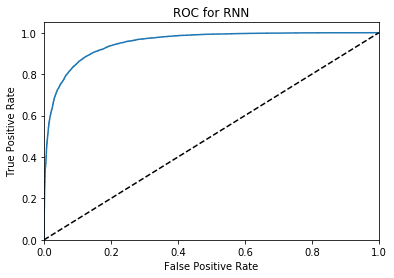

In [0]:
y_test = data_test['sentiment']
scores = model_rnn.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, scores, pos_label=1)

print("AUC for RNN is {}".format(auc(fpr, tpr)))
plt.title('ROC for RNN')
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

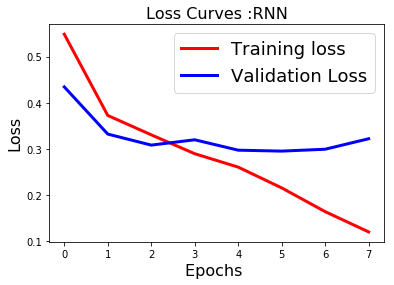

In [0]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN',fontsize=16)
fig1.savefig('loss_rnn.png')
plt.show()

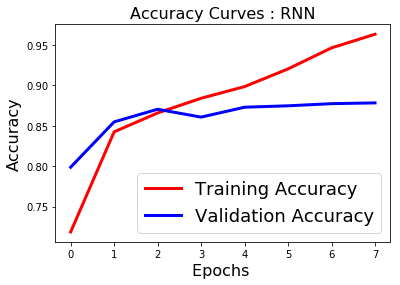

In [0]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RNN',fontsize=16)
fig2.savefig('accuracy_rnn.png')
plt.show()

## Visualizing Recurrent Neural Network Architecture

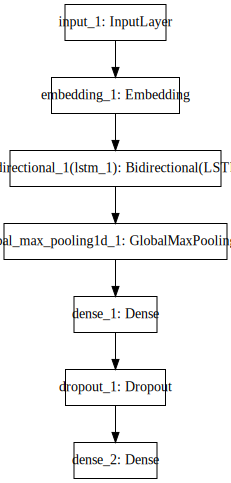

In [0]:
SVG(model_to_dot(model_rnn).create(prog='dot', format='svg'))

In [0]:
plot_model(model_rnn, to_file='model_rnn.png')

References<br>
https://en.wikipedia.org/wiki/Sentiment_analysis<br>
https://nlp.stanford.edu/projects/glove/<br>
https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184<br>
https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/<br>
https://www.kaggle.com/iarunava/google-text-classification-notebook <br>
https://github.com/richliao/textClassifier/blob/master/textClassifierHATT.py <br>
https://richliao.github.io/supervised/classification/2016/12/26/textclassifier-HATN/ <br>
https://medium.com/jatana/report-on-text-classification-using-cnn-rnn-han-f0e887214d5f <br>
https://medium.com/analytics-vidhya/hierarchical-attention-networks-d220318cf87e<br>